# 1. Toy Problem for Model Predictive Interaction Primitives

This section provides an introduction to the MPIP codebase and how it can be used to provide optimal control with interaction primitives. IntPrim must be downloaded and installed as a Python (3.6) package, allong with matplotlib, sklearn, and numpy. The IntPrim library can be found at https://github.com/ir-lab/intprim.

## Import Libraries
We start by first importing the necessary libraries listed below. We spedicically need the scipy.integrate and scipy.optimize library which contain all of the necesary functions for Model Predictive Control.

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
import intprim
import copy

from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import SR1

## Generating Dynamics Model

In the Toy example we will be using a very simple model containing three Degrees of Freedom: dof1 - observable variable (sin), dof2 - latent unobservable variable (cos), dof3 - controllable variable (sec). In this problem there are two random variables: a.) which provides a shift to all dofs and b.) which scales only the two latent unobservable variables. The usual goal in a Human Robor Interaction (HRI) scenario is to use the observation to predict the latent trajectories which are then used as control signals. However due the nature of this data it is impossible to ascertain an accurate prediction of the latent variables since they contain variabability which is completly independant of the observation. The plot of all variables can be seen below, note the extra randomness in the latent variable and latent control trajectories.

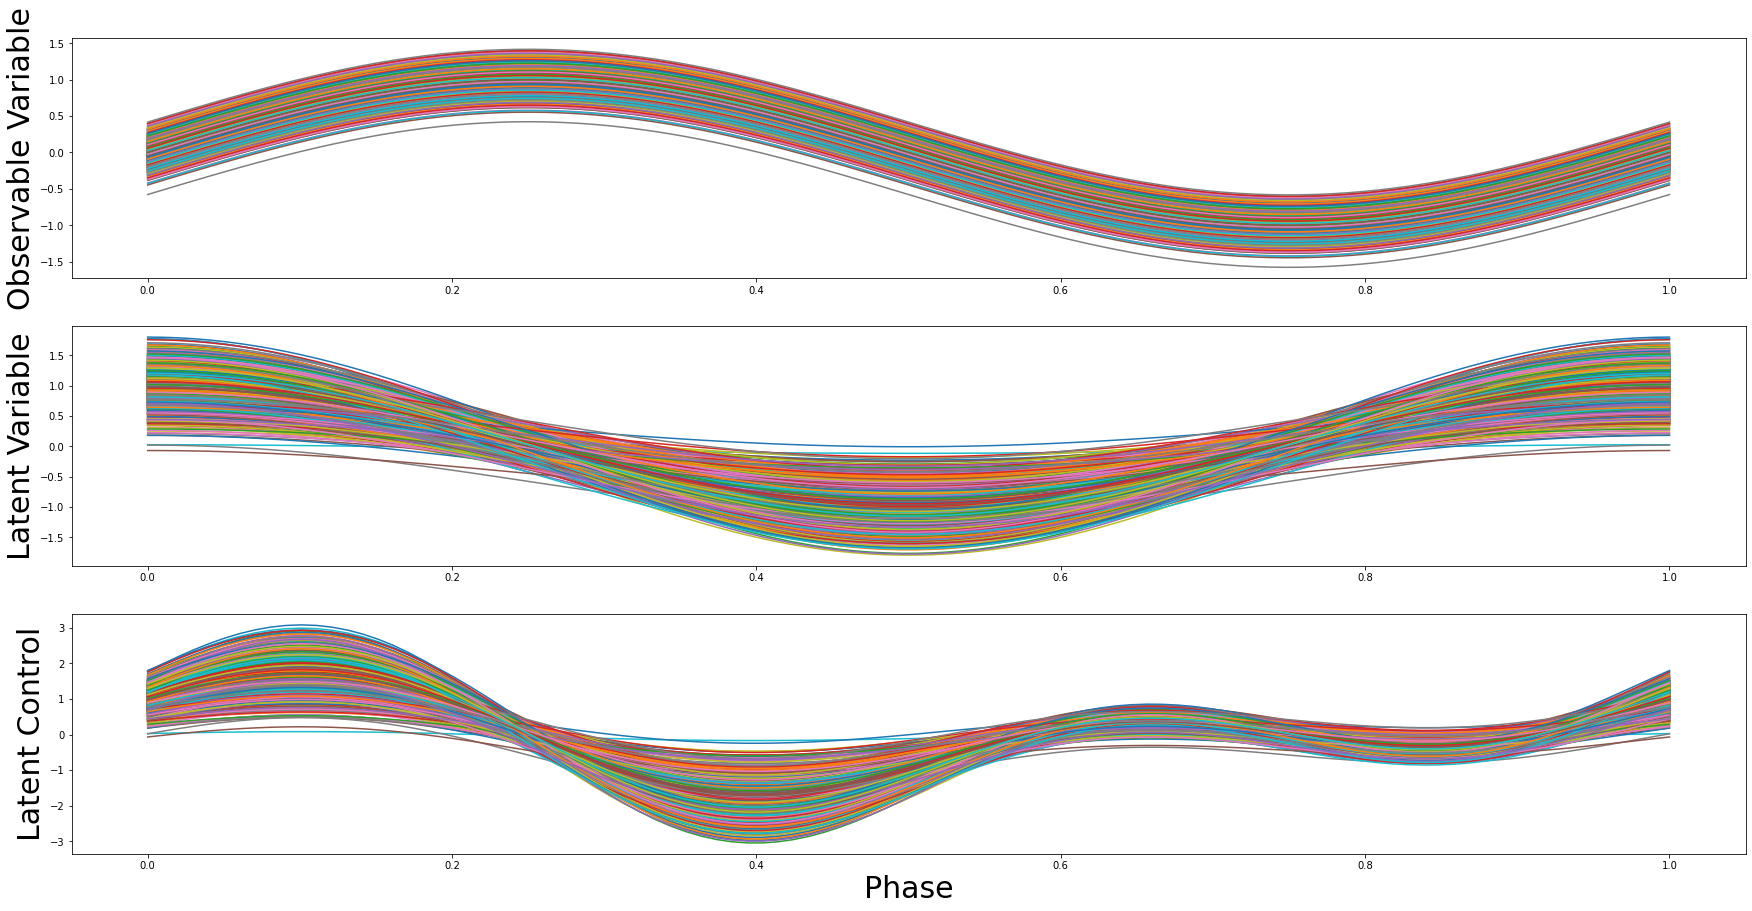

In [77]:
N=1000; offset=.15; latent_scale=.25
phase = np.linspace(0,1,100)
training_trajectories = []
for i in range(N):
    a = np.random.normal(0,offset)
    b = np.random.normal(1,latent_scale)
    dof1 = (a + np.sin(phase*2*np.pi)).reshape(1,-1)
    dof2 = (a + b*np.cos(phase*2*np.pi)).reshape(1,-1)
    dof3 = (a + b*(np.cos(phase*2*np.pi) + np.sin(phase*4*np.pi))).reshape(1,-1)
    temp_data = np.concatenate((dof1, dof2, dof3), axis=0)
    training_trajectories.append(temp_data)
    
fig1 = plt.figure(1,figsize=(30,15))
mean_phase = np.linspace(0,1,100).reshape(1,-1)
ax1 = fig1.add_subplot(311)
ax1.set_ylabel('Observable Variable', fontsize=30)
ax1.plot(mean_phase.T,np.asarray(training_trajectories)[:,0,:].T)

ax2 = fig1.add_subplot(312)
ax2.set_ylabel('Latent Variable', fontsize=30)
ax2.plot(mean_phase.T,np.asarray(training_trajectories)[:,1,:].T)

ax3 = fig1.add_subplot(313)
ax3.set_ylabel('Latent Control', fontsize=30)
ax3.set_xlabel('Phase', fontsize=30)
ax3.plot(mean_phase.T,np.asarray(training_trajectories)[:,2,:].T)
plt.show()

## Generate Interaction Primitive Model

We are using the Interaction Primitives library to first create a probabilist model over the generated training data. This is done by first forming a basis model, we utalize gaussing basis functions in this example, and then fitting the demonstration trajectories to the basis model. We then form a spatiotemporal stochastic filter using the basis model and estimates of the observation and process noise. For the Toy Example example we chose the ensemble kalman filter as it provides the best initial results. It is also of note that in this section we find the upper and lower bounds for the optimization process using the variabability in the training data.

A more detailed tutorial of the intprim library can be found at https://github.com/ir-lab/intprim/blob/master/docs/notebooks/3_indepth_tutorial.ipynb.

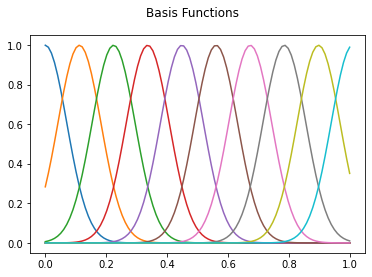

In [78]:
# Define the data axis names.
dof_names = np.array(["Observation", "Latent Variable", "Latent Control"])

# Decompose the handwriting trajectories to a basis space with 10 uniformly distributed Gaussian functions and a variance of 0.1.
basis_model = intprim.basis.GaussianModel(10, .005, dof_names) #0.1
basis_model.plot()
plt.show() 

# Initialize a BIP instance.
primitive = intprim.BayesianInteractionPrimitive(basis_model)

# Train the model.
for trajectory in training_trajectories:
    primitive.add_demonstration(trajectory)

# Calculate sample mean and covariance of demonstrations
demo_mean, demo_cov = primitive.get_basis_weight_parameters()

# Set an observation noise for the demonstrations.
observation_noise = np.diag([0.0001, 1000000**2, 1000000**2])

# Define the active DoF
active_dofs = np.array([0])

# Compute the phase mean and phase velocities from the demonstrations.
phase_velocity_mean, phase_velocity_var = intprim.examples.get_phase_stats(training_trajectories)

# Define a filter to use. Here we use an ensemble Kalman filter
filter = intprim.filter.spatiotemporal.EnsembleKalmanFilter(
    basis_model = basis_model,
    initial_phase_mean = [0.0, phase_velocity_mean],
    initial_phase_var = [1e-5, phase_velocity_var],
    proc_var = 1e-7,
    initial_ensemble = primitive.basis_weights)

# Create test trajectories.
test_trajectories = [training_trajectories[50]]

# Explicitly zero out the x-axis values to illustrate that they are not being used.
test_trajectory_partial = np.array(test_trajectories[0], copy = True)
test_trajectory_partial[1:3,:] = 0.0

# We set a copy of the filter here so we can re-use it later. The filter maintains internal state information and should not be used more than once.
primitive.set_filter(copy.deepcopy(filter))

# Calculate the mean trajectory for plotting.
mean_trajectory = primitive.get_mean_trajectory()

## Performing Inference
We now  perform inference of the latent variable and latent control trajetories over a sequence of observations from the observable trajectory only. While we only run this process once here inference can be performed iteratively at each time step.

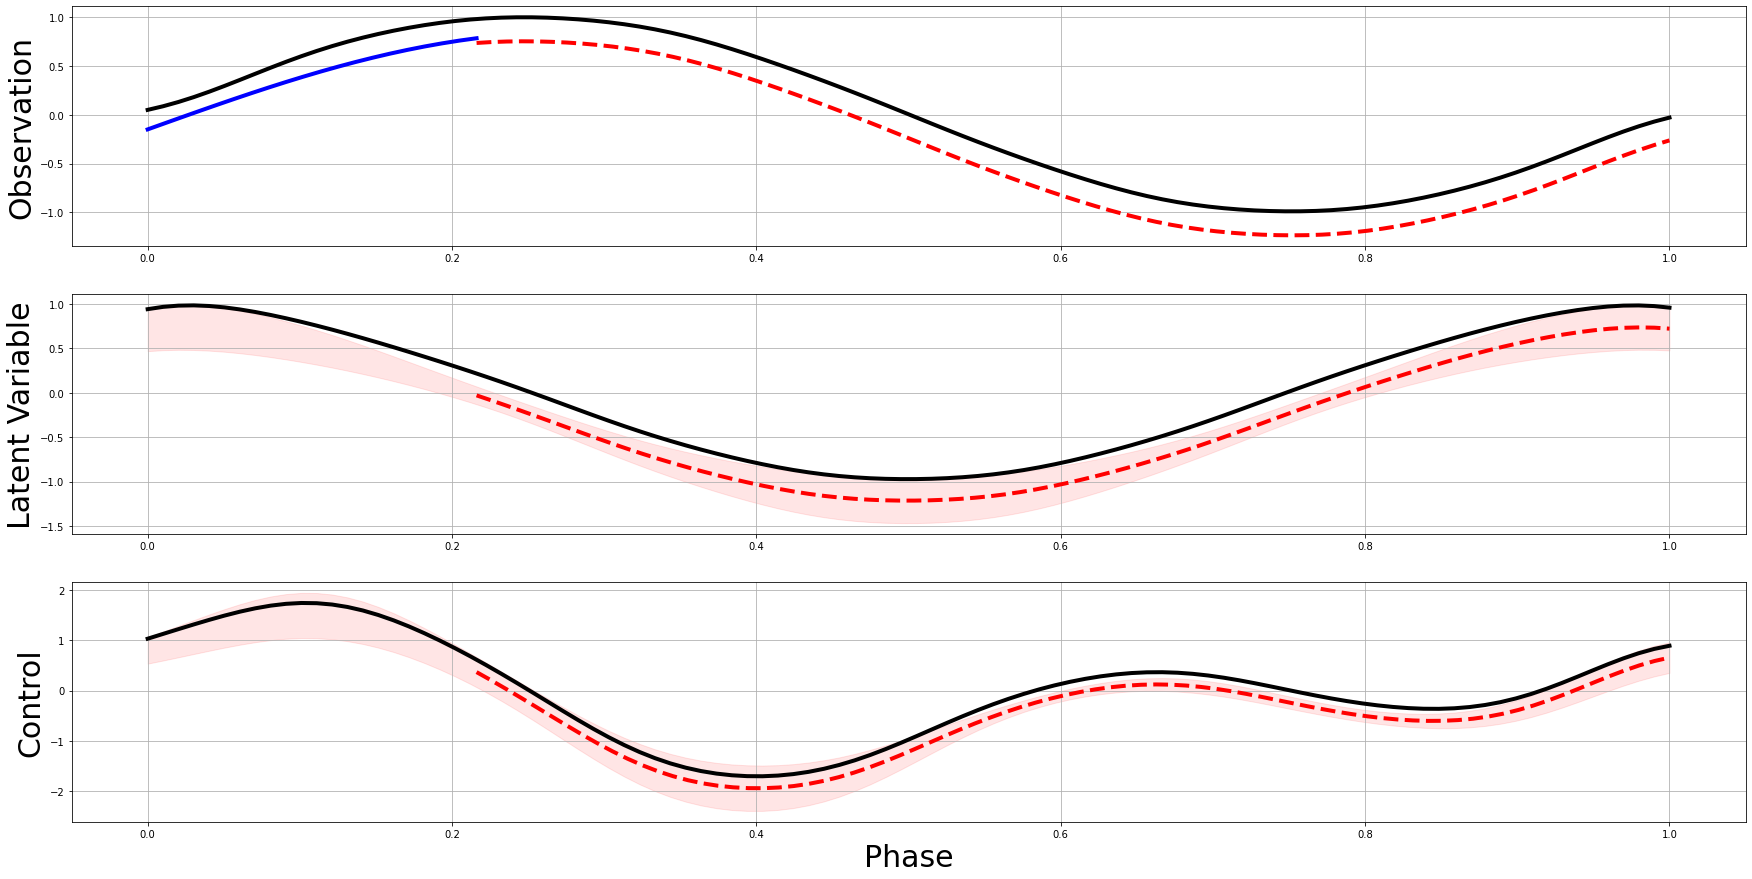

In [79]:
prev_observed_index = 0
observed_index=20
inferred_trajectory,phase,traj_mean,var = primitive.generate_probable_trajectory_recursive(
    test_trajectory_partial[:, prev_observed_index:observed_index],
    observation_noise,
    active_dofs,
    num_samples = test_trajectory_partial.shape[1] - observed_index)

upper_b = traj_mean + np.sqrt(np.diag(var))
lower_b = traj_mean - np.sqrt(np.diag(var))
dictlist = list(basis_model.computed_basis_values.values())
latent_upper_bound=[]
latent_lower_bound=[]
control_upper_bound=[]
control_lower_bound=[]
for i in range (0, 100):
    latent_upper_bound.append(np.dot(dictlist[i],upper_b[10:20]))
    latent_lower_bound.append(np.dot(dictlist[i],lower_b[10:20]))
    control_upper_bound.append(np.dot(dictlist[i],upper_b[20:30]))
    control_lower_bound.append(np.dot(dictlist[i],lower_b[20:30]))

mean_phase = np.linspace(0,1,100)
test_phase = np.linspace(0,phase,test_trajectory_partial[:, :observed_index].shape[1])
infer_phase = np.linspace(phase,1,inferred_trajectory.shape[1])
centers = primitive.basis_model.centers

fig1 = plt.figure(2,figsize=(30,15))
ax1 = fig1.add_subplot(311)
ax1.plot(mean_phase,mean_trajectory[0],'k', linewidth=4)
ax1.plot(test_phase,test_trajectory_partial[0, :observed_index],'b', linewidth=4)
ax1.plot(infer_phase, inferred_trajectory[0],'r--', linewidth=4)
ax1.set_ylabel('Observation', fontsize=30)
ax1.grid(True)

ax2 = fig1.add_subplot(312)
ax2.fill_between(mean_phase, latent_upper_bound, latent_lower_bound, color='r', alpha=0.1)
ax2.plot(mean_phase,mean_trajectory[1],'k', linewidth=4)
ax2.plot(infer_phase, inferred_trajectory[1],'r--', linewidth=4)
ax2.set_ylabel('Latent Variable', fontsize=30)
ax2.grid(True)

ax3 = fig1.add_subplot(313)
ax3.fill_between(mean_phase, control_upper_bound, control_lower_bound, color='r', alpha=0.1)
ax3.plot(mean_phase,mean_trajectory[2],'k', linewidth=4)
ax3.plot(infer_phase, inferred_trajectory[2],'r--', linewidth=4)
ax3.set_ylabel('Control', fontsize=30)
ax3.set_xlabel('Phase', fontsize=30)
ax3.grid(True)

plt.show()

## Performing MPC Minimization

However when we perform this inference we see that there is a high predicted variance across the two latent trajectories due to the high uncertiancy in the model. While this would likely act as a poor (HRI) model, this problem provides an opportunity to instead use model predictive control to select a latent control trajectory to direct the latent variable in a specific manner. 

The MPC process utalizes two simple functions. The gauss_intergrand function simply intergrates over the basis functions, this is important for incorperating the desired phase horizon we want to optimize over. The cost_fuction on the other hand combines the integrated basis functions with the optimized weights, this function is directly optimized by the minimize function which is further constrained by the standard deviation from the predictive model as upper and lower bounds.

If you desire to perform recursive optimization the u0 parameter should be set to the previous cost.x weights to speed up the optimization process.

The green trajectory in the plots indicate the optimal constrained trajectory over the control and latent variable time horizons. As per the cost function you can clearly see how the latent variable trajectory has been reduced towards zero, while the latent control trajectory has been limited by the composed bounds.

By incorperating the MPC process we can therefore choose which control we want to use given desired latent variable trajectories.

`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 154, CG iterations: 22, optimality: 8.77e-09, constraint violation: 0.00e+00, execution time: 0.14 s.
[ 0.27079357  0.93984432  0.13245608 -1.01016751 -1.04757609 -0.13466551
  0.16383983 -0.31144279 -0.44606625  0.59576605]


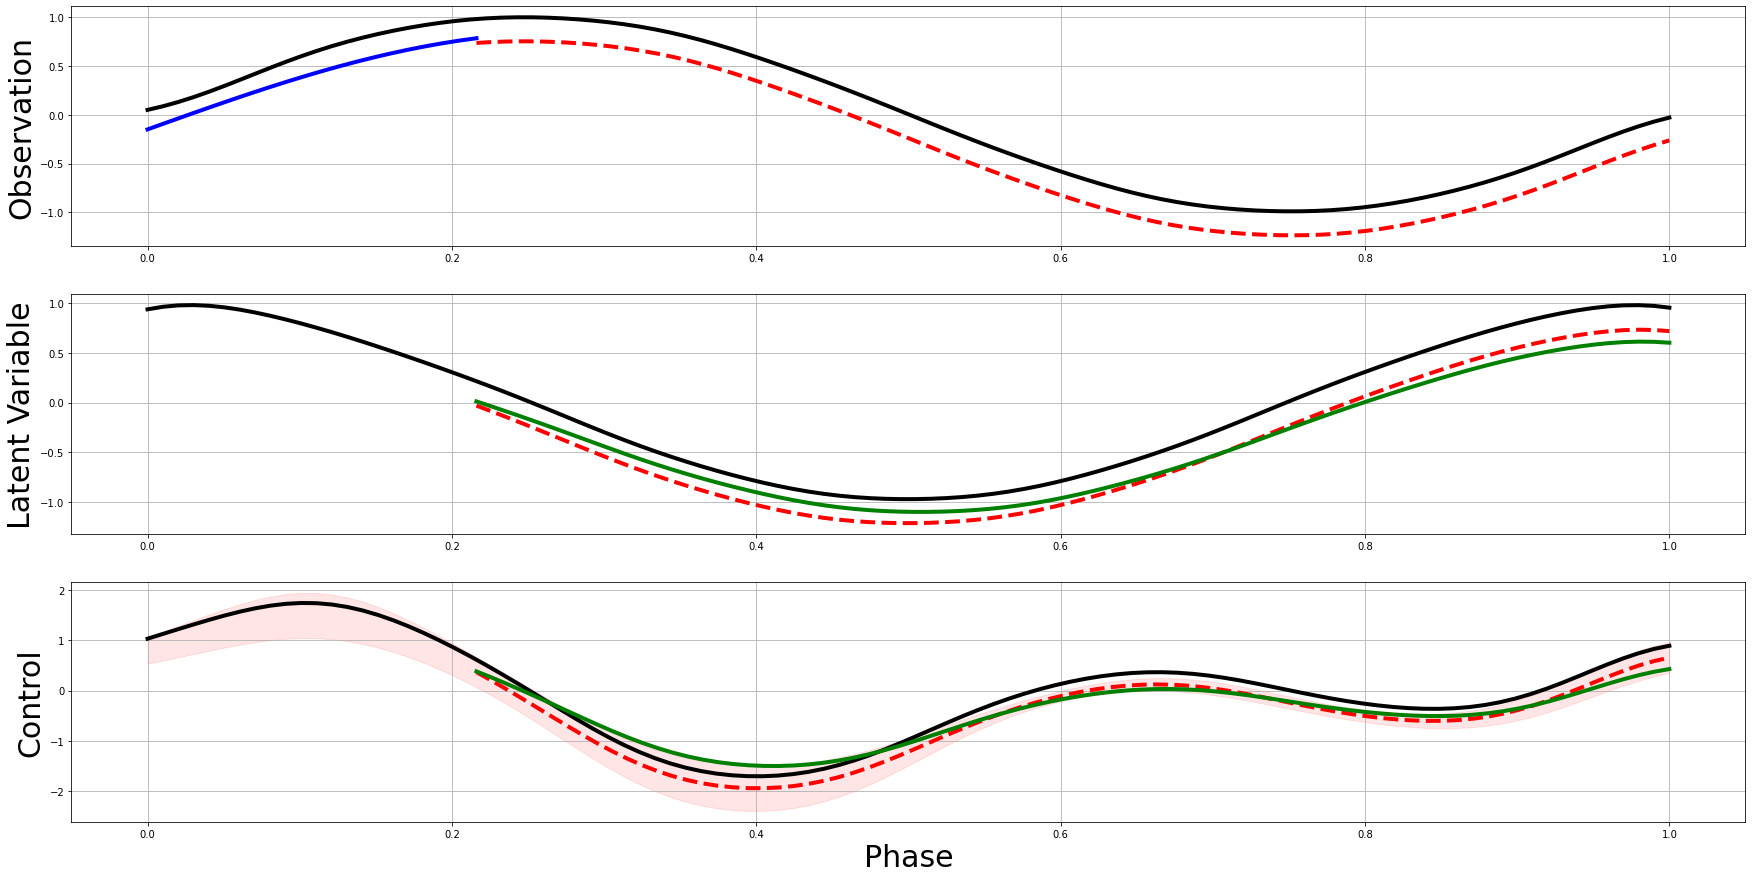

In [80]:
def gauss_intergrand(x,s,u):
    gi = np.exp(-((x - u) ** 2) / (2.0 * s))
    return gi

def cost_function(u, Ix, Iu, cov, u0): # x - weights    i - current integrated mean    m - mean weights
    min_x = np.dot(np.abs(np.dot(u,cov)),Ix)
    C =  min_x
    return C

# create centers vector
centers = primitive.basis_model.centers
std = primitive.basis_model.scale
Ix=[]
Iu=[]
for i in range(centers.shape[0]):
    Ix.append(quad(gauss_intergrand, phase, 2, args=(std,centers[i]))[0])  # * weights[i]
    Iu.append(quad(gauss_intergrand, phase, phase+0.01, args=(std,centers[i]))[0])  # * weights[i]
Ix = np.asarray(Ix)
u0 = traj_mean[20:30]
bounds = Bounds(lower_b[20:30], upper_b[20:30])
cost = minimize(cost_function, u0, args = (Ix, Iu, demo_cov[20:30,10:20], u0), method='trust-constr', jac="2-point", hess=SR1(), options={'verbose': 1}, bounds=bounds)
print(cost.x)
cost_function(cost.x, Ix, Iu, demo_cov[20:30,10:20], u0)

optimized_control_weights=cost.x
optimized_latent_weights=np.dot(cost.x-u0,demo_cov[20:30,10:20])

dictlist = list(basis_model.computed_basis_values.values())
optimized_control_trajectory=[]
optimized_latent_trajectory=[]
latent_inferred_trajectory=[]
for i in range (0, 100):
    optimized_control_trajectory.append(np.dot(dictlist[i],optimized_control_weights))
    latent_inferred_trajectory.append(np.dot(dictlist[i],traj_mean[10:20]))
    optimized_latent_trajectory.append(latent_inferred_trajectory[i]+np.dot(dictlist[i],optimized_latent_weights))

optimized_phase = np.linspace(phase,1,80)

fig1 = plt.figure(2,figsize=(30,15))
ax1 = fig1.add_subplot(311)
ax1.plot(mean_phase,mean_trajectory[0],'k', linewidth=4)
ax1.plot(test_phase,test_trajectory_partial[0, :observed_index],'b', linewidth=4)
ax1.plot(infer_phase, inferred_trajectory[0],'r--', linewidth=4)
ax1.set_ylabel('Observation', fontsize=30)
ax1.grid(True)

ax2 = fig1.add_subplot(312)
ax2.plot(mean_phase,mean_trajectory[1],'k', linewidth=4)
ax2.plot(infer_phase, inferred_trajectory[1],'r--', linewidth=4)
ax2.plot(optimized_phase, optimized_latent_trajectory[20:100], 'g', linewidth=4)
ax2.set_ylabel('Latent Variable', fontsize=30)
ax2.grid(True)

ax3 = fig1.add_subplot(313)
ax3.fill_between(mean_phase, control_upper_bound, control_lower_bound, color='r', alpha=0.1)
ax3.plot(mean_phase,mean_trajectory[2],'k', linewidth=4)
ax3.plot(infer_phase, inferred_trajectory[2],'r--', linewidth=4)
ax3.plot(optimized_phase, optimized_control_trajectory[20:100], 'g', linewidth=4)
ax3.set_ylabel('Control', fontsize=30)
ax3.set_xlabel('Phase', fontsize=30)
ax3.grid(True)

plt.show()

## Performing MPC Maximization

Alternatively to a minimization, many different optimizations are avaliable to choose from simply by changing the cost function. For example we also show a latent variable maximization problem where the probabilistic model is easily adapted to a new scenario. In this example the control trajectory is now bounded on the oposite side of the trajectory as the minimization, in order to increase rather than decrease the latent variable trajectory.

`gtol` termination condition is satisfied.
Number of iterations: 21, function evaluations: 154, CG iterations: 22, optimality: 8.77e-09, constraint violation: 0.00e+00, execution time: 0.098 s.
[ 0.58529395  1.69084513  0.33181096 -1.61245902 -1.67358215 -0.13800265
  0.38005561 -0.42259515 -0.65954691  1.13354298]


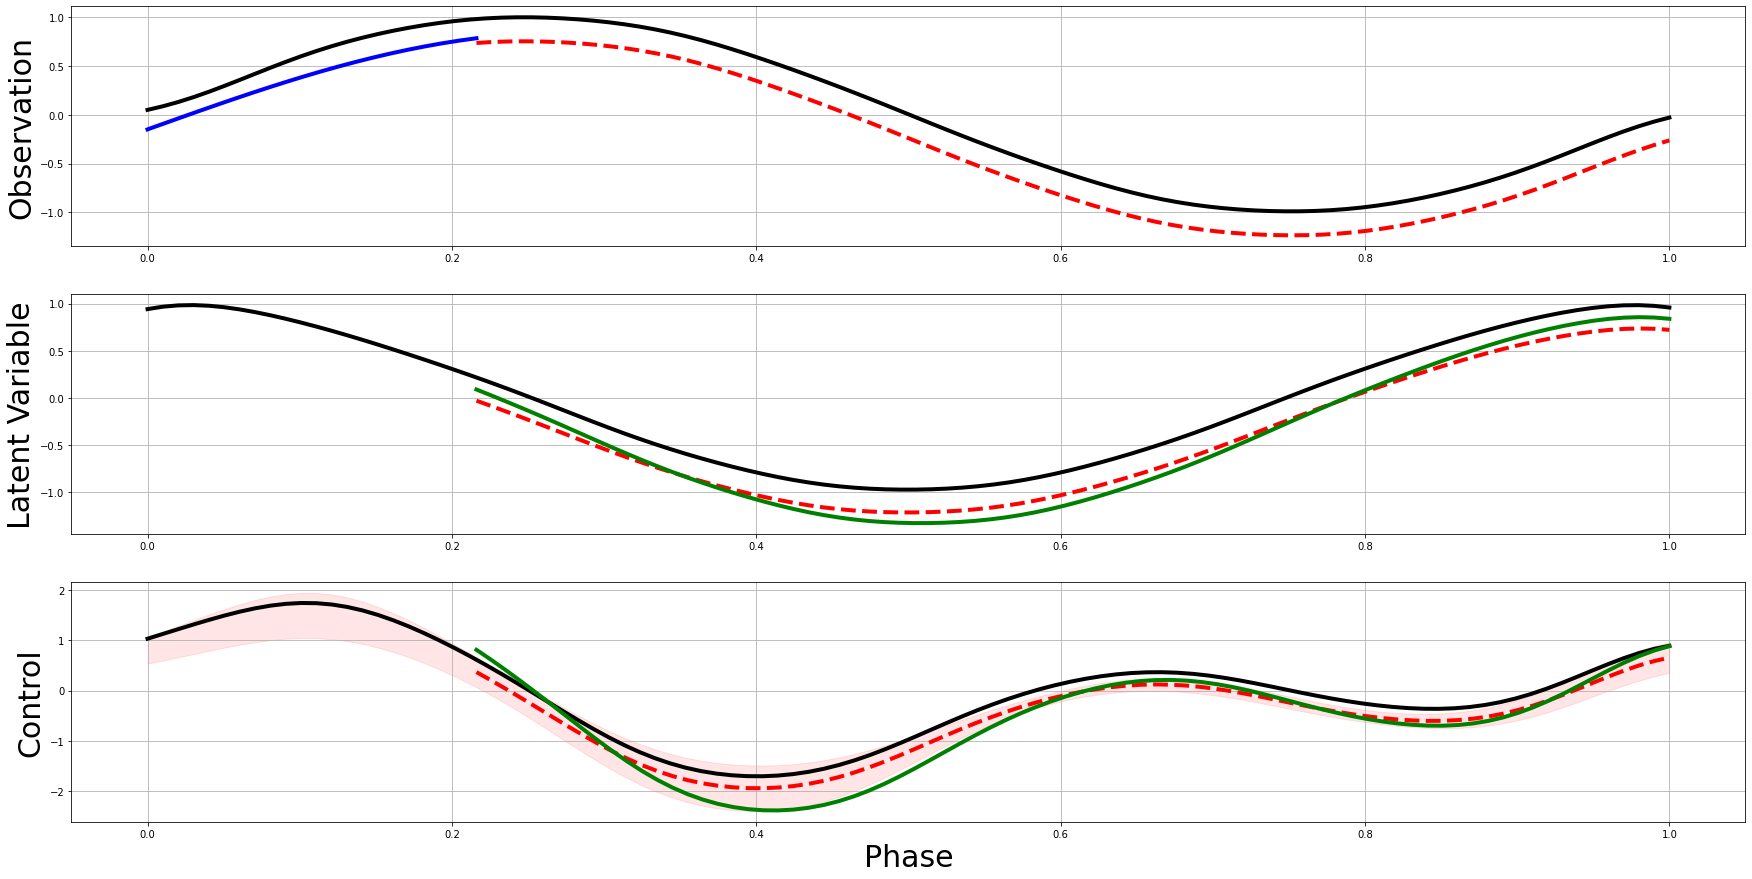

In [81]:
def cost_function(u, Ix, Iu, cov, u0): # x - weights    i - current integrated mean    m - mean weights
    min_x = -np.dot(np.abs(np.dot(u,cov)),Ix)
    C =  min_x
    return C

# create centers vector
centers = primitive.basis_model.centers
std = primitive.basis_model.scale
Ix=[]
Iu=[]
for i in range(centers.shape[0]):
    Ix.append(quad(gauss_intergrand, phase, 2, args=(std,centers[i]))[0])  # * weights[i]
    Iu.append(quad(gauss_intergrand, phase, phase+0.01, args=(std,centers[i]))[0])  # * weights[i]
Ix = np.asarray(Ix)
u0 = traj_mean[20:30]
bounds = Bounds(lower_b[20:30], upper_b[20:30])
cost = minimize(cost_function, u0, args = (Ix, Iu, demo_cov[20:30,10:20], u0), method='trust-constr', jac="2-point", hess=SR1(), options={'verbose': 1}, bounds=bounds)
print(cost.x)
cost_function(cost.x, Ix, Iu, demo_cov[20:30,10:20], u0)

optimized_control_weights=cost.x
optimized_latent_weights=np.dot(cost.x-u0,demo_cov[20:30,10:20])

dictlist = list(basis_model.computed_basis_values.values())
optimized_control_trajectory=[]
optimized_latent_trajectory=[]
latent_inferred_trajectory=[]
for i in range (0, 100):
    optimized_control_trajectory.append(np.dot(dictlist[i],optimized_control_weights))
    latent_inferred_trajectory.append(np.dot(dictlist[i],traj_mean[10:20]))
    optimized_latent_trajectory.append(latent_inferred_trajectory[i]+np.dot(dictlist[i],optimized_latent_weights))

optimized_phase = np.linspace(phase,1,80)

fig1 = plt.figure(2,figsize=(30,15))
ax1 = fig1.add_subplot(311)
ax1.plot(mean_phase,mean_trajectory[0],'k', linewidth=4)
ax1.plot(test_phase,test_trajectory_partial[0, :observed_index],'b', linewidth=4)
ax1.plot(infer_phase, inferred_trajectory[0],'r--', linewidth=4)
ax1.set_ylabel('Observation', fontsize=30)
ax1.grid(True)

ax2 = fig1.add_subplot(312)
ax2.plot(mean_phase,mean_trajectory[1],'k', linewidth=4)
ax2.plot(infer_phase, inferred_trajectory[1],'r--', linewidth=4)
ax2.plot(optimized_phase, optimized_latent_trajectory[20:100], 'g', linewidth=4)
ax2.set_ylabel('Latent Variable', fontsize=30)
ax2.grid(True)

ax3 = fig1.add_subplot(313)
ax3.fill_between(mean_phase, control_upper_bound, control_lower_bound, color='r', alpha=0.1)
ax3.plot(mean_phase,mean_trajectory[2],'k', linewidth=4)
ax3.plot(infer_phase, inferred_trajectory[2],'r--', linewidth=4)
ax3.plot(optimized_phase, optimized_control_trajectory[20:100], 'g', linewidth=4)
ax3.set_ylabel('Control', fontsize=30)
ax3.set_xlabel('Phase', fontsize=30)
ax3.grid(True)

plt.show()

## Modifying MPC Constraints

Alternately, we can modify the bounds placed on the optimization process in order to increase of decrease our trust in the model. For example if we make the bounds very large we are able to reduce the latent trajectory, however not to a perfectly straight horizontal line as expected due to the fact that we have a portion of the model before the current phase which influences the trajectory through the covariance.

`gtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 154, CG iterations: 20, optimality: 6.46e-09, constraint violation: 0.00e+00, execution time: 0.092 s.
[-0.06955883  0.12790741 -0.08374597 -0.35896513 -0.37059385 -0.10860558
 -0.07021666 -0.19038045 -0.21506535  0.01417376]


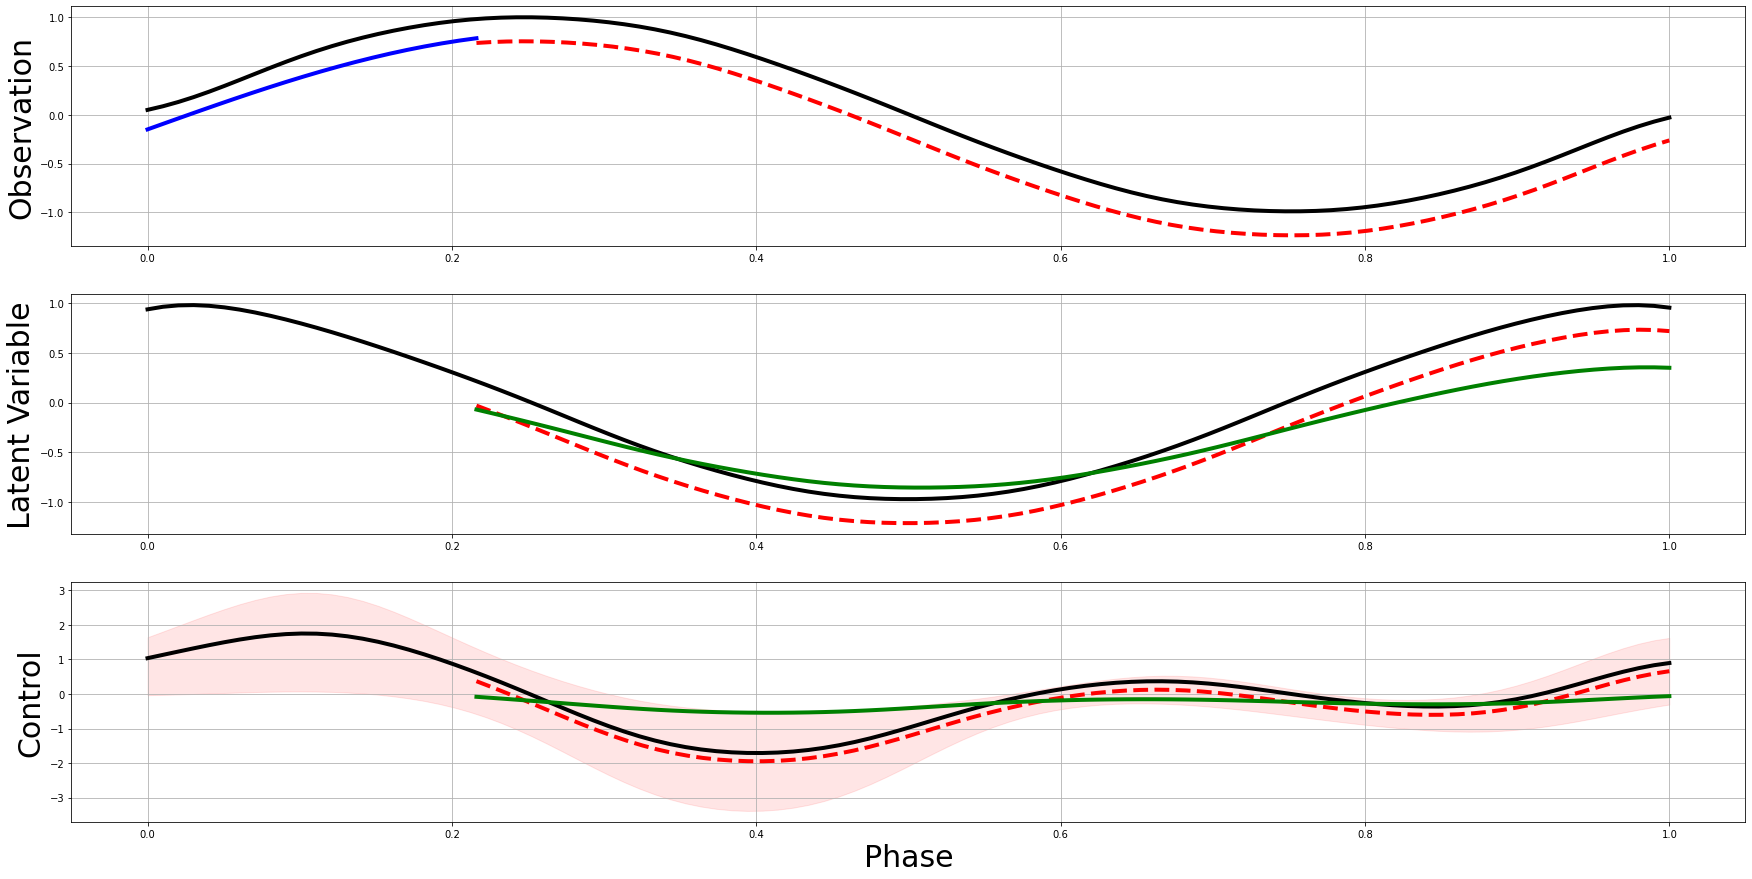

In [82]:
extended_upper_b = traj_mean + np.sqrt(np.diag(var)*10)
extended_lower_b = traj_mean - np.sqrt(np.diag(var)*10)
dictlist = list(basis_model.computed_basis_values.values())
extended_latent_upper_bound=[]
extended_latent_lower_bound=[]
extended_control_upper_bound=[]
extended_control_lower_bound=[]
for i in range (0, 100):
    extended_latent_upper_bound.append(np.dot(dictlist[i],extended_upper_b[10:20]))
    extended_latent_lower_bound.append(np.dot(dictlist[i],extended_lower_b[10:20]))
    extended_control_upper_bound.append(np.dot(dictlist[i],extended_upper_b[20:30]))
    extended_control_lower_bound.append(np.dot(dictlist[i],extended_lower_b[20:30]))


def cost_function(u, Ix, Iu, cov, u0): # x - weights    i - current integrated mean    m - mean weights
    min_x = np.dot(np.abs(np.dot(u,cov)),Ix)
    C =  min_x
    return C

# create centers vector
centers = primitive.basis_model.centers
std = primitive.basis_model.scale
Ix=[]
Iu=[]
for i in range(centers.shape[0]):
    Ix.append(quad(gauss_intergrand, phase, 2, args=(std,centers[i]))[0])  # * weights[i]
    Iu.append(quad(gauss_intergrand, phase, phase+0.01, args=(std,centers[i]))[0])  # * weights[i]
Ix = np.asarray(Ix)
u0 = traj_mean[20:30]
bounds = Bounds(extended_lower_b[20:30], extended_upper_b[20:30])
cost = minimize(cost_function, u0, args = (Ix, Iu, demo_cov[20:30,10:20], u0), method='trust-constr', jac="2-point", hess=SR1(), options={'verbose': 1}, bounds=bounds)
print(cost.x)
cost_function(cost.x, Ix, Iu, demo_cov[20:30,10:20], u0)

optimized_control_weights=cost.x
optimized_latent_weights=np.dot(cost.x-u0,demo_cov[20:30,10:20])

dictlist = list(basis_model.computed_basis_values.values())
optimized_control_trajectory=[]
optimized_latent_trajectory=[]
latent_inferred_trajectory=[]
for i in range (0, 100):
    optimized_control_trajectory.append(np.dot(dictlist[i],optimized_control_weights))
    latent_inferred_trajectory.append(np.dot(dictlist[i],traj_mean[10:20]))
    optimized_latent_trajectory.append(latent_inferred_trajectory[i]+np.dot(dictlist[i],optimized_latent_weights))

optimized_phase = np.linspace(phase,1,80)

fig1 = plt.figure(5,figsize=(30,15))
ax1 = fig1.add_subplot(311)
ax1.plot(mean_phase,mean_trajectory[0],'k', linewidth=4)
ax1.plot(test_phase,test_trajectory_partial[0, :observed_index],'b', linewidth=4)
ax1.plot(infer_phase, inferred_trajectory[0],'r--', linewidth=4)
ax1.set_ylabel('Observation', fontsize=30)
ax1.grid(True)

ax2 = fig1.add_subplot(312)
ax2.plot(mean_phase,mean_trajectory[1],'k', linewidth=4)
ax2.plot(infer_phase, inferred_trajectory[1],'r--', linewidth=4)
ax2.plot(optimized_phase, optimized_latent_trajectory[20:100], 'g', linewidth=4)
ax2.set_ylabel('Latent Variable', fontsize=30)
ax2.grid(True)

ax3 = fig1.add_subplot(313)
ax3.fill_between(mean_phase, extended_control_upper_bound, extended_control_lower_bound, color='r', alpha=0.1)
ax3.plot(mean_phase,mean_trajectory[2],'k', linewidth=4)
ax3.plot(infer_phase, inferred_trajectory[2],'r--', linewidth=4)
ax3.plot(optimized_phase, optimized_control_trajectory[20:100], 'g', linewidth=4)
ax3.set_ylabel('Control', fontsize=30)
ax3.set_xlabel('Phase', fontsize=30)
ax3.grid(True)

plt.show()

## Adding MPC Control Cost

the last feature this tutorial will cover is the addition of a aditional cost metrics such as one which resists changes in the control trajectory per the control horizon. In this example we are using a control horizon of 0.1 therefore the trajectory with remain close to the original trajectory for the first 0.1 of the phase after which it will adjust back to the minimal trajectory. The horizons of the control and vatent variable of interest can be adjusted in this way to limit their effect on the overall trajectory.

/home/geoffrey/anaconda3/envs/osimProsthesis/lib/python3.6/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`xtol` termination condition is satisfied.
Number of iterations: 547, function evaluations: 10098, CG iterations: 1236, optimality: 3.67e-03, constraint violation: 0.00e+00, execution time:  1.7 s.
[ 0.03245888  0.18924866  0.23213347 -1.31131314 -0.42041912 -0.13525465
  0.05682312 -0.34126051 -0.26414663  0.04948419]


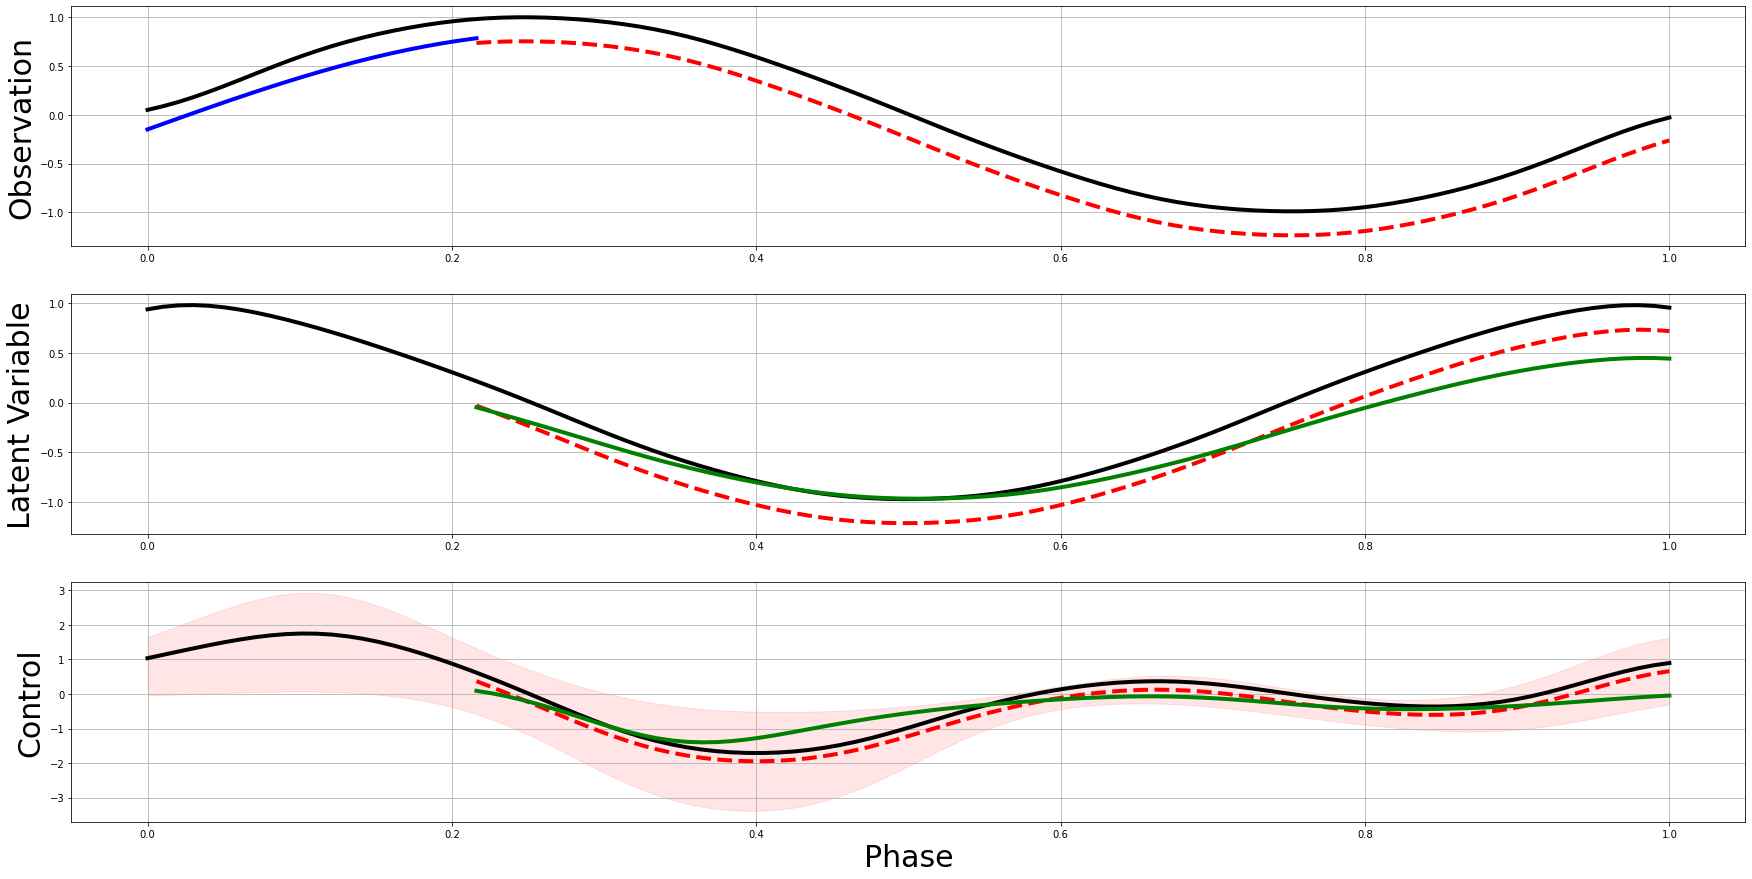

In [83]:
def cost_function(u, Ix, Iu, cov, u0): # x - weights    i - current integrated mean    m - mean weights
    min_x = np.dot(np.abs(np.dot(u,cov)),Ix)
    min_u = (np.dot(np.abs(u-u0),Iu))
    C =  min_x + min_u
    return C

# create centers vector
centers = primitive.basis_model.centers
std = primitive.basis_model.scale
Ix=[]
Iu=[]
for i in range(centers.shape[0]):
    Ix.append(quad(gauss_intergrand, phase, 2, args=(std,centers[i]))[0])  # * weights[i]
    Iu.append(quad(gauss_intergrand, phase, phase+0.1, args=(std,centers[i]))[0])  # * weights[i]
Ix = np.asarray(Ix)
u0 = traj_mean[20:30]
bounds = Bounds(extended_lower_b[20:30], extended_upper_b[20:30])
cost = minimize(cost_function, u0, args = (Ix, Iu, demo_cov[20:30,10:20], u0), method='trust-constr', jac="2-point", hess=SR1(), options={'verbose': 1}, bounds=bounds)
print(cost.x)
cost_function(cost.x, Ix, Iu, demo_cov[20:30,10:20], u0)

optimized_control_weights=cost.x
optimized_latent_weights=np.dot(cost.x-u0,demo_cov[20:30,10:20])

dictlist = list(basis_model.computed_basis_values.values())
optimized_control_trajectory=[]
optimized_latent_trajectory=[]
latent_inferred_trajectory=[]
for i in range (0, 100):
    optimized_control_trajectory.append(np.dot(dictlist[i],optimized_control_weights))
    latent_inferred_trajectory.append(np.dot(dictlist[i],traj_mean[10:20]))
    optimized_latent_trajectory.append(latent_inferred_trajectory[i]+np.dot(dictlist[i],optimized_latent_weights))

optimized_phase = np.linspace(phase,1,80)

fig1 = plt.figure(5,figsize=(30,15))
ax1 = fig1.add_subplot(311)
ax1.plot(mean_phase,mean_trajectory[0],'k', linewidth=4)
ax1.plot(test_phase,test_trajectory_partial[0, :observed_index],'b', linewidth=4)
ax1.plot(infer_phase, inferred_trajectory[0],'r--', linewidth=4)
ax1.set_ylabel('Observation', fontsize=30)
ax1.grid(True)

ax2 = fig1.add_subplot(312)
ax2.plot(mean_phase,mean_trajectory[1],'k', linewidth=4)
ax2.plot(infer_phase, inferred_trajectory[1],'r--', linewidth=4)
ax2.plot(optimized_phase, optimized_latent_trajectory[20:100], 'g', linewidth=4)
ax2.set_ylabel('Latent Variable', fontsize=30)
ax2.grid(True)

ax3 = fig1.add_subplot(313)
ax3.fill_between(mean_phase, extended_control_upper_bound, extended_control_lower_bound, color='r', alpha=0.1)
ax3.plot(mean_phase,mean_trajectory[2],'k', linewidth=4)
ax3.plot(infer_phase, inferred_trajectory[2],'r--', linewidth=4)
ax3.plot(optimized_phase, optimized_control_trajectory[20:100], 'g', linewidth=4)
ax3.set_ylabel('Control', fontsize=30)
ax3.set_xlabel('Phase', fontsize=30)
ax3.grid(True)

plt.show()